In [195]:
import os
import math
from functools import reduce
import itertools
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV, LassoCV
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns

from helper_functions import fetch_data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


Here I'm pulling in box score stats at even strength and power play regular season stats for all players from 20072008 to present. All data provided by evolving-hockey.com

In [196]:
#ev_df, pp_df = fetch_data()
#ev_df.to_csv('ev_player_goal_data.csv')
#pp_df.to_csv('pp_player_goal_data.csv')

#reading in csv files to dataframes
ev_df = pd.read_csv('ev_player_goal_data.csv')
pp_df = pd.read_csv('pp_player_goal_data.csv')


Here I'm grouping the rows together of the dataframes because some players played for multiple teams so I'm roling them up so there will be one row for each player/season combo

In [197]:
def group_data(df):
    df.season = df.season.astype(int)
    df['prev_season'] = df['season'] - 10001
    groupby_columns = ['player', 'api_id', 'season', 'player_upper', 
                       'birthday', 'position', 'shoots',
                       'prev_season', 'position_type', 
                       'season_age']
    agg_columns = ['g', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf']
    df = df.groupby(groupby_columns)[agg_columns].sum().reset_index()
    return df

ev_df = group_data(ev_df)
pp_df = group_data(pp_df)

In [198]:
#join the pp stats to the regular stats

total_df = ev_df.merge(pp_df[['api_id', 'g', 'a1', 'a2', 'season',
                              'points', 'toi', 'gp', 'isf', 'iff', 'icf']], 
                       on=['api_id', 'season'],
                       how='left',
                       suffixes=[None, '_pp'])

total_df.fillna(0, inplace=True)


#create dataframe of season to season goal correlation
next_df = total_df.merge(total_df[['api_id', 'season', 'prev_season', 'g', 'g_pp', 'season_age']], 
                         how='inner',
                         left_on=['api_id', 'season'], 
                         right_on=['api_id', 'prev_season'],
                         suffixes=[None, '_next'])

next_df['total_goals_next'] = next_df['g_next'] + next_df['g_pp_next']
next_df['total_goals'] = next_df['g'] + next_df['g_pp']

In [199]:
#Now start building a new linear model that takes into affect new features and maybe use 
#ridge or lasso for feature selection. Also doing a bagging regressor with this too
#TODO: need to do some better feature/parameter creation i bet
#features:
#2. player age done
#4. position (dummy variable) done
#5. toi_gp done
#6. previous years goals done
#7. previous years a1 done
#8. previous years a2 done
#9. previous years points done
#10. Past average of past two years goals
#11. pp_toi done
#12. shooting percentage done
#13. shooting percentage difference from carreer shooting percentage over span of data done
#14. career goals per season average over span of data done

#position dummy variable
next_df = pd.concat([next_df, pd.get_dummies(next_df['position_type'], prefix='pos')], axis=1)
#toi_gp
next_df['toi_gp'] = round(next_df['toi']/next_df['gp'], 2)
next_df['sh_percent'] = round(next_df['g']/next_df['isf'], 3)
next_df['sh_percent_pp'] = round(next_df['g_pp']/next_df['isf_pp'], 3)

#avg goals over career
#TODO redo this number of season counts
next_df = next_df.sort_values(['api_id', 'season'])
next_df["number_season"] = next_df.groupby("api_id")["season"].rank(method="first", ascending=True)

next_df['goals_shift'] = next_df['g'] + next_df['g'].shift(1)
next_df['cum_goals'] = np.where(next_df['api_id'] == next_df['api_id'].shift(1), 
                                    next_df['goals_shift'], 
                                    next_df['g'])
next_df['avg_goals_season'] = next_df['cum_goals']/next_df['number_season']

#avg shooting percentage over career
next_df['cum_shots'] = np.where(next_df['api_id'] == next_df['api_id'].shift(1), 
                                    next_df['isf'] + next_df['isf'].shift(1), 
                                    next_df['isf'])
next_df['avg_sh_perc'] = round(next_df['cum_goals']/next_df['cum_shots'], 3)

#diff of season sh% from career avg
next_df['sh_perc_diff'] = next_df['sh_percent'] - next_df['avg_sh_perc']

#TODO get last two seasons avg
next_df['next_prev_season'] = next_df['prev_season'] - 10001
next_df = next_df.merge(next_df[['api_id', 'season', 'g']], 
                        left_on=['api_id', 'prev_season'], 
                        right_on=['api_id','season'], how='left')
next_df = next_df.merge(next_df[['api_id', 'season_x', 'g_x']], 
                        left_on=['api_id', 'next_prev_season'], 
                        right_on=['api_id','season_x'], how='left',
                        suffixes=[None, '_z'])
next_df['g_avg_past_2_seasons'] = (next_df['g_y'] + next_df['g_x_z'])/2

#prorate goals for strike shortened season
#TODO research maybe a better way to prorate things
#TODO or do it both ways my way and the twins way
next_df['g_x'] = np.where(next_df['season_x'] == 20122013, 
                          (next_df['g_x']/next_df['gp']) * 82, next_df['g_x'])
next_df['g_pp'] = np.where(next_df['season_x'] == 20122013, 
                           (next_df['g_pp']/next_df['gp']) * 82, next_df['g_pp'])

#TODO: add columns for goals last season and the season before maybe

#dropping the columns i don't need and renaming some to be more useful
columns = ['player', 'api_id', 'season_x', 'player_upper', 'position', 'shoots', 'season_age_next',
           'g_x', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf', 'g_pp', 'a1_pp', 'a2_pp',
           'points_pp', 'toi_pp', 'gp_pp', 'isf_pp', 'iff_pp', 'season_next', 'g_next', 'pos_D',
           'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 
           'sh_perc_diff', 'g_avg_past_2_seasons', 'total_goals_next']

renamed_columns = ['player', 'api_id', 'season', 'player_upper', 'position', 'shoots', 'next_season_age',
                   'g', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf', 'g_pp', 'a1_pp', 'a2_pp',
                   'points_pp', 'toi_pp', 'gp_pp', 'isf_pp', 'iff_pp', 'season_next', 'g_next', 'pos_D',
                   'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 
                   'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons', 'total_goals_next']
next_df = next_df[columns]
next_df.columns = renamed_columns

In [200]:
next_df = next_df.replace(np.nan, 0)
feature_columns = ['next_season_age',
                   'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp',
                   'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
                   'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 
                   'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons'] 


x_train, x_test, y_train, y_test = train_test_split(next_df[feature_columns], 
                                                    next_df[['total_goals_next']], 
                                                    test_size=0.2, random_state=8675309)

# Correlations

Let's look at the correlations between the existing features and our target variables to spot collinearity or features that don't correlate to extract them as inputs to the model. This can be done faster using some sort of regularized regression but to start we'll keep things a little manual and straight forward while relying on our domain knowledge to build the best model we can.

In [8]:
next_df.corr().loc[feature_columns, 'total_goals_next'].sort_values(ascending=False).head(15)

g                       0.684367
g_pp                    0.639443
isf                     0.630840
iff                     0.621761
isf_pp                  0.611125
avg_goals_season        0.610721
iff_pp                  0.605430
toi_pp                  0.597530
a1                      0.591287
g_avg_past_2_seasons    0.490026
a1_pp                   0.486727
a2_pp                   0.436594
a2                      0.411799
gp                      0.382072
pos_F                   0.380486
Name: total_goals_next, dtype: float64

In [9]:
#have to use f_classif because there are negative numbers
'''
Selecting the ten best features using ANOVA f test and then will compare a regular linear regression results 
to that of Lasso/Ridge/ElasticNet
'''
KBest = SelectKBest(score_func = f_classif, k=10)
KBest = KBest.fit(x_train, y_train.values[:,0])


As we can see the SelectKBest features and the correlation matrix doesn't disagree much in what are the best
features in the model to predict next seasons goal. Next we need to see which of these are highly correlated as I would guess a few of them are. Looking at the correlation matrix below lets take out iff, iff_pp, isf_pp as those are highly correlated to other stats. We will replace them with the next three best features that aren't also highly multicolinear which is 'pos_F', 'a1_pp', and 'gp' as you can see in the matrix below

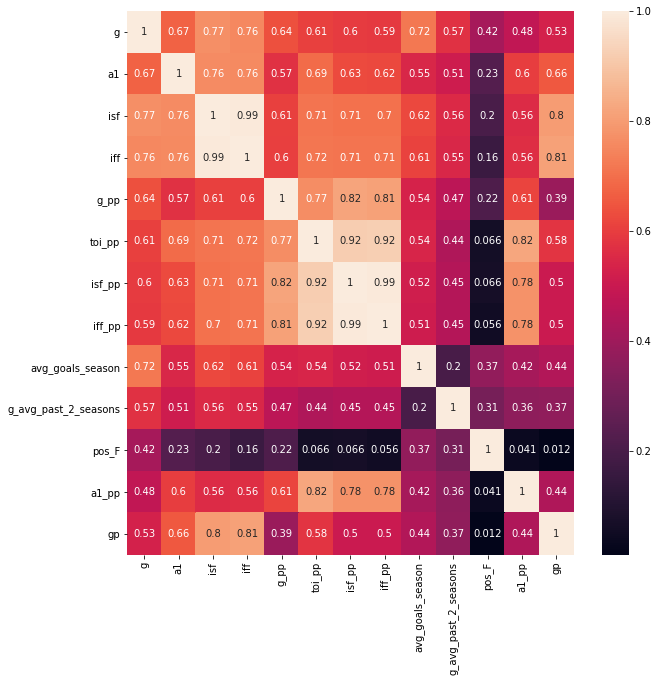

In [354]:
corr_matrix = x_train.loc[:, list(x_train.columns[KBest.get_support()]) + ['pos_F', 'a1_pp', 'gp']].corr()
# Draw the heatmap 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, fmt='.2g')
plt.show()

In [18]:
#Our Final selected features as a blend of SelectKBest and Correlation Matrices
selected_features = ['g', 'g_pp', 'isf', 'toi_pp', 'isf_pp', 'avg_goals_season', 'g_avg_past_2_seasons',
                     'pos_F', 'gp', 'a1']

In [257]:
#Standardizing the datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#If you are repeating code a lot it's best to wrap it in a function as you'll see below it makes training
#the models a lot easier and comparing their result on the test data sets
#TODO need to create a pipeline for the standardization of features before passing to the 
#estimator 
def cv_model(x, y, model, n_estimators: int, n_splits: int, scaler, features: list=[]):
    estimator = BaggingRegressor(model, n_estimators=n_estimators, bootstrap=True)
    
    scaler.fit(x[features])
    feature_array = scaler.transform(x[features])
    estimator.fit(feature_array, y.values[:, 0])

    y_hat_values = estimator.predict(feature_array)
    #Testing the coefficient of determination in the training set. R^2 is the proportion
    #of the variance in the dependent variable that is predictable from the independent variables
    r_squared = estimator.score(feature_array, y)
    #Mean Squared Error is used to compare between different models where the smaller the number the better
    #An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
    #estimator or MVUE(minimum Variance Unbiased Estimator)
    mse = mean_squared_error(y, y_hat_values)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, y_hat_values)

    print(f"Building model with features: {features}")
    print(("Baseline linear model training set metrics:\n"
           f"R^2 for test set: {round(r_squared, 4)}\n"
           f"Mean Squared Error for training set: {round(mse, 4)}\n"
           f"Root Mean Squared Error for training set: {round(rmse, 4)}\n"
           f"Mean Absolute Error for training set: {round(mae, 4)}\n"
           ))
 
    return estimator

In [258]:
#make producing Out of Sample metrics easier
def oos_stats(x_test, y_test, features, model, model_name, scaler):
    standardized_df = scaler.transform(x_test[features])
    mse = mean_squared_error(y_test, model.predict(standardized_df))
    rmse = math.sqrt(mean_squared_error(y_test, model.predict(standardized_df)))
    mae = mean_absolute_error(y_test, model.predict(standardized_df))
    r_sq = model.score(standardized_df, y_test)
    print(f"Building {model_name} with features: {features}")
    print((f"{model_name} model Out of Sample metrics:\n"
           f"R^2: {round(r_sq, 4)}\n"
           f"Mean Squared Error: {round(mse, 4)}\n"
           f"Root Mean Squared Error: {round(rmse, 4)}\n"
           f"Average Mean Absolute Error for test set: {round(mae, 4)}"
           ))

# BaggingRegressor

For all the regression models, I will be using Scikit Learns Bagging Regressor. The Bagging Regressor is a meta estimator that combines multiple regressions trained from data randomly drawn with replacement from our training data set known as Bootstrappping. Bagging itself means Bootstrap plus aggregating. So to break it down the bagging regressor gets passed a parameter `n_estimators` which will tell it how many base estimators to make. In order to create the dataset for each base estimator to train on, the algorithim will pull from the training data randomly with replacement. This means that you could draw the same row multiple times. For example, say i have a bag with a red jelly bean, a black jelly bean, and a white jelly bean. I need to draw a sample of three jelly beans. I draw the first one its red, I then replace the red jelly bean back in the bag meaning I could draw it again. I repeat this until i have drawn three jelly beans and this is my sample.

By creating these multiple models based on random sampling it will allow us to create a distribution of what the number of goals the model expects a player to score in the next season. This allows us to judge the uncertainty of the model in its predictions by determining the variance and standard deviation of the results of each model for the player. (Brownlee)

The first regression we will be working with in this article is the Ordinary Least Squares Linear regresssion. It is commonly abbreviated to OLS and that is how I will refer to it from now on.

In [259]:
estimator = cv_model(x_train, y_train, LinearRegression(), 500, 10, scaler, features=selected_features)

Building model with features: ['g', 'g_pp', 'isf', 'toi_pp', 'isf_pp', 'avg_goals_season', 'g_avg_past_2_seasons', 'pos_F', 'gp', 'a1']
Baseline linear model training set metrics:
R^2 for test set: 0.6068
Mean Squared Error for training set: 25.961
Root Mean Squared Error for training set: 5.0952
Mean Absolute Error for training set: 3.6616



In [260]:
oos_stats(x_test, y_test, selected_features, estimator, 'Linear Regression', scaler)

Building Linear Regression with features: ['g', 'g_pp', 'isf', 'toi_pp', 'isf_pp', 'avg_goals_season', 'g_avg_past_2_seasons', 'pos_F', 'gp', 'a1']
Linear Regression model Out of Sample metrics:
R^2: 0.6032
Mean Squared Error: 26.8544
Root Mean Squared Error: 5.1821
Average Mean Absolute Error for test set: 3.6482


# OLS Assumptions

There are four principal assumptions which justify the use of linear regression models for purposes of inference or prediction. This list of assumptions is taken from the Duke notes on linear regression:

1. linearity and additivity of the relationship between dependent and independent variables:

    * The expected value of dependent variable is a straight-line function of each independent variable, holding the others fixed.

    * The slope of that line does not depend on the values of the other variables.

    * The effects of different independent variables on the expected value of the dependent variable are additive.

2. statistical independence of the errors (in particular, no correlation between consecutive errors in the case of time series data)

3. homoscedasticity (constant variance) of the errors

    * versus time (in the case of time series data)

    * versus the predictions

    * versus any independent variable

4. normality of the error distribution. (Duke)

# Violations of linearity or additivity

Violations of linearity or additivity are extremely serious: if you fit a linear model to data which are nonlinearly or nonadditively related, your predictions are likely to be seriously in error, especially when you extrapolate beyond the range of the sample data. (Duke) We'll look at this by plotting the observed versus predicted values to see if they have a linear relationship. We'll also look at the plot of the residuals vs. predicted values which should be disributed around a horizontal line with constant variance

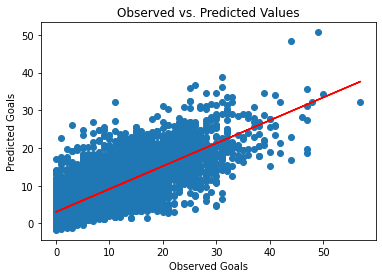

In [310]:
#total scatter correlation
#this is the test of linearity
scaler.fit(x_train[selected_features])
m, b = np.polyfit(y_train.values[:,0], estimator.predict(scaler.transform(x_train[selected_features])), 1)
plt.plot(y_train, m * y_train + b, color="red")
plt.scatter(y_train, estimator.predict(scaler.transform(x_train[selected_features])))
plt.xlabel("Observed Goals")
plt.ylabel("Predicted Goals")
plt.title("Observed vs. Predicted Values")
plt.show()

As you can see the observed versus have a decent positive linear relation so there is no violation of linearity but these graphs are deceiving so it is best to look at the residuals versus predicted values.

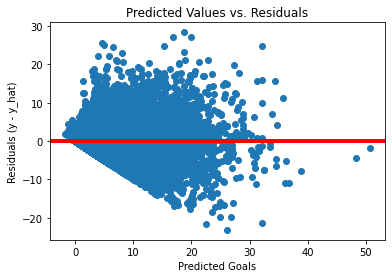

In [308]:
plt.scatter(estimator.predict(scaler.transform(x_train[selected_features])),
            y_train.values[:, 0]-estimator.predict(scaler.transform(x_train[selected_features])))

plt.xlabel("Predicted Goals")
plt.ylabel("Residuals (y - y_hat)")
plt.title("Predicted Values vs. Residuals")
plt.axhline(y=0, color="red", lw=4)
plt.show()

As we can see with this there are some issues with the smaller values in dataset and not having negative residuals. This is most likely because of the fact you can't score negative goals and your total the next season will never go below zero. 

# Violations of independence
Here we check to see if any of our features are correlated with the residuals. Like with our predicted values the variance should be constant between each feature and the residual for that row. Again we will probably see issues at the lower end because of the non negative values of our data.

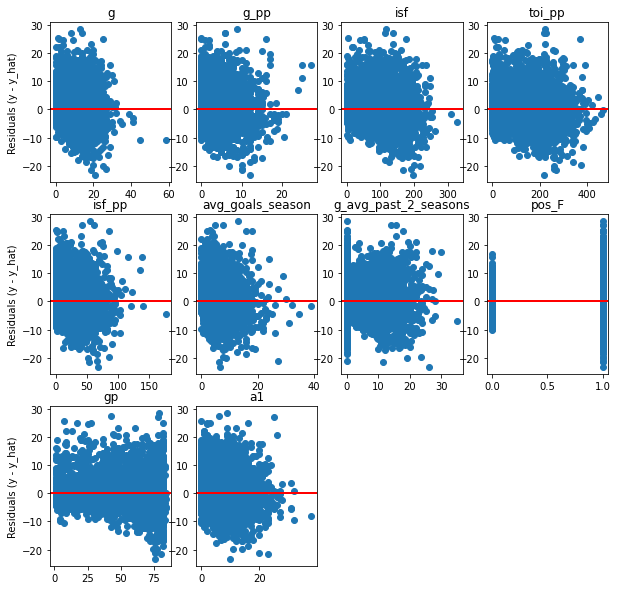

In [342]:
import math
x_row = 0
fig, axs = plt.subplots(3, 4, figsize=(10,10))
for i, f in enumerate(selected_features):
    test = [x[i] for x in scaler.transform(x_train[selected_features])]
    residuals = y_train.values[:, 0]-estimator.predict(scaler.transform(x_train[selected_features]))
    axs[math.floor(x_row), i%4].scatter(x_train[f], residuals)

    #axs[math.floor(x_row), i%4].set_xlabel(f"{f}")
    if math.floor(x_row) in [0,1,2] and i%4 == 0:
        axs[math.floor(x_row), i%4].set_ylabel("Residuals (y - y_hat)")
    axs[math.floor(x_row), i%4].set_title(f"{f}")
    axs[math.floor(x_row), i%4].axhline(y=0, color="red", lw=2)
    x_row += .25
    
#removing empty plots
fig.delaxes(axs[2][2])
fig.delaxes(axs[2][3])

As with our predicted vs residual graphs we see the same issues for values closer to zero and the absence of negative residuals. However, I think we can confirm the lack of correlation between the features and our residuals showing our features are staistically independent from our errors.

# Violations of homoscedasticity

To check this we again look out our predicted vs. residuals plot we made above. And again it doesn't look like the variance of the residuals is a constant value across the predicted values. When your data isn't homoscedastic it's considered heteroscedastic meaning that the variability of the errors is different acros the vector of our predicted values.

> \[Hetereoscedasticity\] make\[s\] it difficult to gauge the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide or too narrow. In particular, if the variance of the errors is increasing over time, confidence intervals for out-of-sample predictions will tend to be unrealistically narrow. Heteroscedasticity may also have the effect of giving too much weight to a small subset of the data (namely the subset where the error variance was largest) when estimating coefficients. (Duke)

While this might be a minor violation of this assumption, its more likely because we are using OLS regression on a counting data set instead of a continuous one. In the next sections of this series we will look at regressions that deal with these types of datasets, but for now the results of our regression is still pretty decent so we'll stick with it

# Violations of normality

We will look to make sure the errors, or residuals, from our regression are normally distributed. The best way to do this graphically is with a QQ plot with compares the residuals at a quantile level to the distribution we are assuming they came from in this case the normal distribution. Below you can see the average is close to 0 but not quite again which is a condition of normality in the distribution of our residuals.

In [318]:
resid_avg = np.average(residuals)
print(f"Average of the residuals: {resid_avg}")

Average of the residuals: -0.0003209471771901632


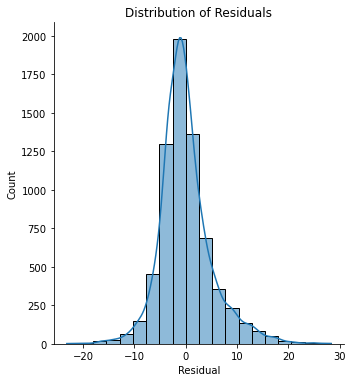

In [353]:
import seaborn as sns
sns.displot(data=residuals, kde=True, bins=20)
plt.xlabel("Residual")
plt.title("Distribution of Residuals")
plt.show()

The plot looks sort of like a normal distribution, but upon closer inpsection it appears that the mean isn't 0 which is what we would want it to be in a normal distribution. We can investigate this further by looking at a QQ plot of the reisudals as described below:

> A Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that’s roughly straight. Here’s an example of a Normal Q-Q plot when both sets of quantiles truly come from Normal distributions. (UVA)

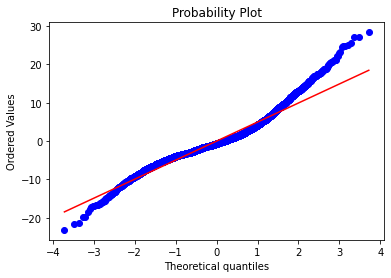

In [315]:
#QQ plot or normal quantile plot
import scipy
scipy.stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

The S Shaped curve of our QQ plot is showing that our residuals are influenced by outliers in our residuals. Particularly this S shaped curve demonstrates heavy tail outliers in our residuals which can be seen in the histogram plot above. This means that the assumptions of Normality aren't quite met, but they are pretty close and probably aren't large enough to severely effect the predictions of the model (Love).

# Beyond OLS Regression

# Ridge Regression
In ridge regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients. So ridge regression puts constraint on the coefficients. The penalty term (alpha) regularizes the coefficients such that if the coefficients take large values the optimization function is penalized. So, ridge regression shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity (Bhattacharyya).

"If you’ve heard of them before, you must know that they work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. These are called ‘regularization’ techniques," (AARSHAY JAIN). In Ridge Regression it uses the L2 Norm regularization which is penalty equivalent to square of the magnitude of coefficients. L2 Norm is also known as the [Euclidean Norm](https://en.m.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm) which is basically the distance from the origin to the point of the vector.

In sklearn alpha is used to determine the penalty applied to the features as it uses the `||y - Xw||^2_2 + alpha * ||w||^2_2` as the objective, or loss, function. So basically what this is saying is that the lower the alpha value the closer your Ridge Regression will be to a regular OLS regression. The higher the value of alpha the more the regression will penalize those features that have high colinearity. This helps with model complexity and overfitting of the model from colinearity. Ridge regression is penalized by the sum of the coefficients squared. 

In [156]:
#Normally most people refer to the penalization variable as lambda when talking about Ridge Regressions in math
#or R. However we need to convert those lambdas to our alpha for the sklearn. There is a link in the sources 
#that discus the math behind this in detail
def lambda_to_alpha(lambda_value, samples):
    return (lambda_value * samples) / 2.0

# Cross Validation

Here we'll talk about RidgeCV and how it works and why I'm using it etc. and cross validation in general and my cross validation scheme here where I'm cross validating on top of the CV models and calculating the average scores of each model on the test set hold out from the training data (Brownlee).

In [355]:
from sklearn.linear_model import RidgeCV
lambdas_ridge = [0.01, 0.025, 0.05, .075, 0.1]
alpha_ridge = [lambda_to_alpha(l, x_train.shape[0]) for l in lambdas_rapm]
ridge_estimator = cv_model(x_train, y_train, RidgeCV(alphas=alpha_ridge, cv=10), 500, 10, scaler, 
                           features=feature_columns)

Building model with features: ['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Baseline linear model training set metrics:
R^2 for test set: 0.6235
Mean Squared Error for training set: 24.8614
Root Mean Squared Error for training set: 4.9861
Mean Absolute Error for training set: 3.5992



In [357]:
oos_stats(x_test, y_test, feature_columns, ridge_estimator, 'Ridge Regression', scaler)

Building Ridge Regression with features: ['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Ridge Regression model Out of Sample metrics:
R^2: 0.6137
Mean Squared Error: 26.1439
Root Mean Squared Error: 5.1131
Average Mean Absolute Error for test set: 3.6013


# Lasso Regression

We are going to repeat the steps above but this time use a lasso regression instead of a Ridge Regression. I'm going to pass all the columns to the Lasso Regression instead of just some of them. I could have done this with the Ridge Regression, but it doesn't reduce colinear values to 0 like lasso does due to its cost function so the effect wouldn't be as demonstrable. But with Lasso as you'll see below, the algorithm will reduce to 0 any features that are highly colinear. The Lasso Regression applies a penalty weight to the L1 norm(or taxicab/Manhattan distance) of the features which is the sum of the absolute value of the components of the feature vector and uses this formula as its optimization function `(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1`. Lasso uses the sum of the coefficients instead of the coefficients squared which is why you can get zero values for coefficients in Lasso (Bahattacharyya). This and the formula above are for Scikit Learn, R and other languages will use a different optimazation function that most likely will use a lambda penalty parameter instead of alpha.


In [267]:
#the LassoCV takes a much smaller values of lambda to get a good result. 
#Tis is mainly due to the different cost functions for the regression. 
#Lasso uses L1 normalization while Ridge uses L2. 
from sklearn.linear_model import LassoCV
lasso_lambdas = [.01, .001, .002, .003, .0001]
lasso_alphas = [lambda_to_alpha(l, x_train.shape[0]) for l in lasso_lambdas]
lasso_estimator = cv_model(x_train, y_train, LassoCV(alphas=lasso_alphas, max_iter=1000), 
                           500, 10, scaler, features=feature_columns)

Building model with features: ['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Baseline linear model training set metrics:
R^2 for test set: 0.6073
Mean Squared Error for training set: 25.9312
Root Mean Squared Error for training set: 5.0923
Mean Absolute Error for training set: 3.6679



In [268]:
oos_stats(x_test, y_test, feature_columns, lasso_estimator, 'Lasso Regression', scaler)

Building Lasso Regression with features: ['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Lasso Regression model Out of Sample metrics:
R^2: 0.5975
Mean Squared Error: 27.2365
Root Mean Squared Error: 5.2189
Average Mean Absolute Error for test set: 3.6789


# ElasticNet Regression

ElasticNet Regression is a combination or Ridge and Lasso Regressions. It combines the cost functions of both Lasso and Ridge Regression(L1 and L2 Regularisation respectively) to try to get the best of both worlds (Oleszak). In most literature this is called an alpha parameter with alpha=0 being a pure ridge regression and alpha=1 being Lasso. Of course Scikit Learn uses alpha as its lambda (confusing I know but I find it better to refer to them as everyone else does instead of what Scikit does to avoid confusion).

So the alpha parameter is called the `l1_ratio` in the sklearn ElasticNet model. Its a value from 0 to 1 with the same setup as the alpha. It also takes an `alphas` parameter like the Ridge/Lasso models which is the penalization hyperparameter as above. With `ElasticNet` there are now two hyperparameters to tune: `l1_ratio` (alpha) and `alphas` (lambda). Im using a combination of lambdas from the previous two models and a standard alpha selection found in the Scikit Learn docs on ElasticNetCV that states that you should have more values closer to 1 than 0.

In [271]:
from sklearn.linear_model import ElasticNetCV
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]
elastic_alphas = lasso_alphas + alpha_ridge
elastic_estimator = cv_model(x_train, y_train, ElasticNetCV(l1_ratio=l1_ratios, alphas=elastic_alphas), 
                             500, 10, scaler, features=feature_columns)

Building model with features: ['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
Baseline linear model training set metrics:
R^2 for test set: 0.6126
Mean Squared Error for training set: 25.5805
Root Mean Squared Error for training set: 5.0577
Mean Absolute Error for training set: 3.6353



In [272]:
oos_stats(x_test, y_test, feature_columns, elastic_estimator, 'ElasticNet Regression', scaler)

Building ElasticNet Regression with features: ['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D', 'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
ElasticNet Regression model Out of Sample metrics:
R^2: 0.6079
Mean Squared Error: 26.5336
Root Mean Squared Error: 5.1511
Average Mean Absolute Error for test set: 3.6316


# Comparing the Four Models

In [368]:
standardized_df = scaler.transform(x_test)
print(f"Comparing R^2 of Models on Test Set:")
print((f"Elastic Net: {round(elastic_estimator.score(standardized_df, y_test), 4)}\n"
       f"Lasso: {round(lasso_estimator.score(standardized_df, y_test), 4)}\n"
       f"Ridge: {round(ridge_estimator.score(standardized_df, y_test), 4)}\n"
       ))
print("Comparing MAE of Models on Test Set:")
print((f"Elastic Net: {round(mean_absolute_error(elastic_estimator.predict(standardized_df), y_test), 4)}\n"
       f"Lasso: {round(mean_absolute_error(lasso_estimator.predict(standardized_df), y_test), 4)}\n"
       f"Ridge: {round(mean_absolute_error(ridge_estimator.predict(standardized_df), y_test), 4)}\n"
       ))

Comparing R^2 of Models on Test Set:
Elastic Net: 0.6079
Lasso: 0.5975
Ridge: 0.6137

Comparing MAE of Models on Test Set:
Elastic Net: 3.6316
Lasso: 3.6789
Ridge: 3.6013



# Improving the Model
So it looks like Ridge Regression is our best performing model overall although Elastic Net scores close as well. Overall are these scores are all right. They aren't great but they aren't awful, generally I'd like a R squared of above .70 if possible although that varies with what your are predicting too. Sometimes an R^2 of .6 is very good given the dificulty of what you are predicting. As a good baseline model these metrics are pretty good for the minimal amount of work put into acutally building the model itself. So now that there is baseline its time work on improving the model some.

One thing that could help improve the model is to split our power play features and even strength features into two seperate models. Right now we are using power play stats along with even strength stats from the previous season to predict the total goals for a player. Sometimes it is better to have multiple simpler models instead of one more complex model. This is sort of the idea behind Boosting in machine learning as well which is beyond the scope of this article but keep it in mind as I'll probably touch on it in future entries

# Sources
Ridge and Lasso Regression: L1 and L2 Regularization by Saptashwa Bhattacharyya
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

Ridge Regression Cost Function by Aleksy Bilogur 
https://www.kaggle.com/residentmario/ridge-regression-cost-function

Alpha parameter in ridge regression is high Cross Validated
https://stats.stackexchange.com/questions/166950/alpha-parameter-in-ridge-regression-is-high

A Complete Tutorial on Ridge and Lasso Regression in Python by AARSHAY JAIN
https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

What are the differences between ridge regresssion using R's Glmnet and Python's sklearn Cross Validated
https://stats.stackexchange.com/questions/160096/what-are-the-differences-between-ridge-regression-using-rs-glmnet-and-pythons

Scikit Learn Ridge Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

A Gentle Introduction to the Bootstrap Method by Jason Brownlee
https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/

Regularization: Ridge, Lasso and Elastic Net by Michał Oleszak
https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

Intuitions on L1 and L2 Regularisation by Raimi Karim
https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261

Hastie, T., Tibshirani, R.,, Friedman, J. (2001). The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc.. 

Norm (Mathematics) 
https://en.wikipedia.org/wiki/Norm_(mathematics)#Absolute-value_norm

Repeated k-Fold Cross-Validation for Model Evaluation in Python by Jason Brownlee
https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/

What does calling fit() multiple times on the same model do Stack Overflow
https://stackoverflow.com/questions/49841324/what-does-calling-fit-multiple-times-on-the-same-model-do

Linear Regression Models, Duke University
http://people.duke.edu/~rnau/testing.htm

Understanding Q-Q Plots, University of Virginia Library
https://data.library.virginia.edu/understanding-q-q-plots/

Data Science for Biological, Medical and Health Research: Notes for 431 by Thomas E. Love PhD
https://thomaselove.github.io/2018-431-book/assessing-normality.html